# Mishra's Bird - Constrained Optimization

### Written by José Hugo Elsas, Tecgraf (PUC-Rio), BR.

*Last updated Monday, 6 May 2019.*

This is a GPyOpt contrained optimization example for the [Mishra's Bird Function](https://en.wikipedia.org/wiki/Test_functions_for_optimization). The global minimum is:

$f(-3.1302468,-1.5821422) = -106.7645367$

The important imports are the [GPy](https://sheffieldml.github.io/GPy/) and [GPyOpt](https://github.com/SheffieldML/GPyOpt) libraries, and the initial_design function to select the first points to initialize the method. This function requires dealing with constraint, which is done using the acquisition function of [Expected Improvement](https://www.researchgate.net/publication/248818761_The_application_of_Bayesian_methods_for_seeking_the_extremum) (EI) with [Probability of Feasibility](https://dl.acm.org/citation.cfm?id=3044997) (PoF). For references of Probability of Feasibility, read [Gardner et. al. (2014)](https://stat.columbia.edu/~cunningham/pdf/GardnerICML2014.pdf), [Gelbart (2015)](https://dash.harvard.edu/bitstream/handle/1/17467236/GELBART-DISSERTATION-2015.pdf?sequence=4&isAllowed=y) and [Schonlau (2015)](https://www.collectionscanada.gc.ca/obj/s4/f2/dsk3/ftp04/nq22234.pdf). A modified version of the Bayesian Optimization method is required, named ModularConstrainedBayesianOptimization.

In [1]:
%pylab inline
import GPy
import GPyOpt
import numpy as np
import matplotlib.pyplot as plt
from GPyOpt.experiment_design import initial_design
from GPyOpt.acquisitions.EI import AcquisitionEI
from GPyOpt.methods import ModularBayesianOptimization

Populating the interactive namespace from numpy and matplotlib


The definition of the Mishra's, with constraint, function is given by the functions below:

In [2]:
def mishra_bird(x,y):
    f1 = sin(y)*np.exp((1-np.cos(x))**2)
    f2 = cos(x)*np.exp((1-np.sin(y))**2)
    return (f1+f2+(x-y)**2)

def disk_contraint(x,y):
    return (25-(x+5)**2-(y+5)**2)

Create (xv,yv) variables to be able to plot and visualize the function in 2D and 3D

In [3]:
X_ax = np.linspace(-10.,0.,401)
Y_ax = np.linspace(-6.5,0.,401)

xv, yv = np.meshgrid(X_ax, Y_ax, sparse=False, indexing='ij')

zv = np.zeros(xv.shape)

for i in range(X_ax.shape[0]):
    for j in range(Y_ax.shape[0]):
        g1 = disk_contraint(X_ax[i],Y_ax[j])
        if( g1>=0 ):
            zv[i,j] = mishra_bird(X_ax[i],Y_ax[j])
        else:
            zv[i,j] = np.nan

To the left, the 2D heatmap plot of the Himmelblau function, and to the right, a 3D rendering of the same function. There is one global minimum, which correspond to the single dip in the picture below.

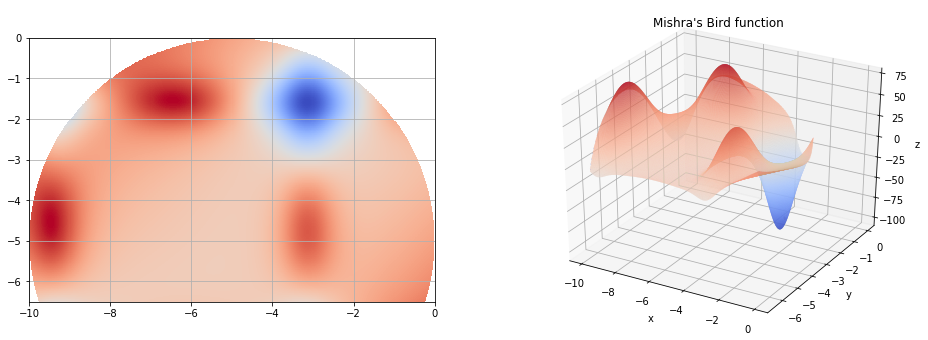

In [4]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
ax.grid()
ax.imshow(zv.T,cmap=cm.coolwarm,extent=(-10,0,-6.5,0),origin='bottom')

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_surface(xv, yv, zv, rstride=1, cstride=1,
                cmap=cm.coolwarm, edgecolor='none',
                vmin = -110, vmax = 80)

ax2.set_title('Mishra\'s Bird function');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
plt.show()

The search space of the optimization problem is the box $[-10,0] \times [-6.5,0]$, with continuous variables. 

There are two GP models: One for interpolating the objective function, and another for interpolating the constraint. In this case the constraint is very simple, just a parabolic function, but it might not be the case in other problems.

The acquisition function is the Expected Improvement with Probability of Feasibility extension, named AcquisitionEI. The evaluator is the standard serial evaluator.

The initial choice of points is done via the initial_design function, according to a [Latin Hypercube](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) sampling. The objective function and the constraints are evaluated on those points before the Bayesian optimization loop. 

In [5]:
np.set_printoptions(precision=6)

objective = None   # Externally evaluated objective function used 

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-10.,0.)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (-6.5,0.)}]
space = GPyOpt.Design_space(space = space)

model    = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c  = [model_c1]

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

acquisition = AcquisitionEI(model,space,optimizer=aquisition_optimizer,model_c=model_c)

# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

num_init = 6
typ_init = 'latin'
X_init = initial_design(typ_init,space,num_init)

Y_init = np.zeros((X_init.shape[0],1))
C_init = np.zeros((X_init.shape[0],1))

for i in range(num_init):
    Y_init[i,0] = mishra_bird(X_init[i,0],X_init[i,1])
    C_init[i,0] = disk_contraint(X_init[i,0],X_init[i,1])
    
print(np.hstack((X_init,Y_init,C_init)))

[[ -5.833333  -3.791667   5.832032  22.845486]
 [ -9.166667  -5.958333  24.036563   6.720486]
 [ -0.833333  -0.541667   6.197348 -12.237847]
 [ -4.166667  -1.625    -31.746589  12.914931]
 [ -7.5       -4.875      8.749581  18.734375]
 [ -2.5       -2.708333 -16.735383  13.498264]]


The main external loop is executed using the ModularConstrainedBayesianOptimization object, initialized with the interpolation method of usual Gaussian Process, the acquisition function is the Expected Improvement w/ PoF, and default jitter used for a standard Bayesian Optimization loop.

In [6]:
iter_count = 50-num_init
current_iter = 0
X_step = X_init
Y_step = Y_init
C_step = C_init 

while current_iter < iter_count:    
    bo_step = ModularBayesianOptimization(model, space, objective, acquisition, evaluator, 
                                          X_init = X_step, Y_init = Y_step, C_init = C_step, 
                                          model_c = model_c, normalize_Y = False)
    
    x_next = bo_step.suggest_next_locations()
    y_next = np.array(mishra_bird(x_next[0][0],x_next[0][1]))# func.f(x_next) rosenbrock(X_ax[i],Y_ax[j])
    c1_next = disk_contraint(x_next[0][0],x_next[0][1])
    c_next = np.array([c1_next])
    print("Current iteration - ",current_iter," : ",np.array([x_next[0][0],x_next[0][1],y_next,c_next[0]]))
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    C_step = np.vstack((C_step, c_next))
    
    current_iter += 1

Current iteration -  0  :  [ -3.691251  -1.157511 -55.408939   8.52245 ]
Current iteration -  1  :  [ -3.595568  -0.967305 -48.35413    6.764938]
Current iteration -  2  :  [ -3.435124  -1.302262 -85.236708   8.877899]
Current iteration -  3  :  [  -3.263321   -1.46496  -102.474274    9.487438]
Current iteration -  4  :  [  -3.057931   -1.552269 -105.933868    9.341518]
Current iteration -  5  :  [  -3.179639   -1.716056 -104.038758   10.901996]
Current iteration -  6  :  [  -3.130692   -1.576527 -106.760172    9.785517]
Current iteration -  7  :  [-0.921183 -6.5      33.519684  6.113255]
Current iteration -  8  :  [ -2.436893  -0.994376 -38.974253   2.385464]
Current iteration -  9  :  [-8.059947 -1.40618  29.483402  2.721179]
Current iteration -  10  :  [  -3.109568   -1.607684 -106.615469    9.918456]
Current iteration -  11  :  [-4.784726 -6.5       2.749849 22.703657]
Current iteration -  12  :  [-0.346411 -3.479083 11.61725   1.030918]
Current iteration -  13  :  [-3.707317 -4.51

Plotting the heatmap of the Mishra's Bird function against the scatterplot of the queried points, one obtains the pciture below:

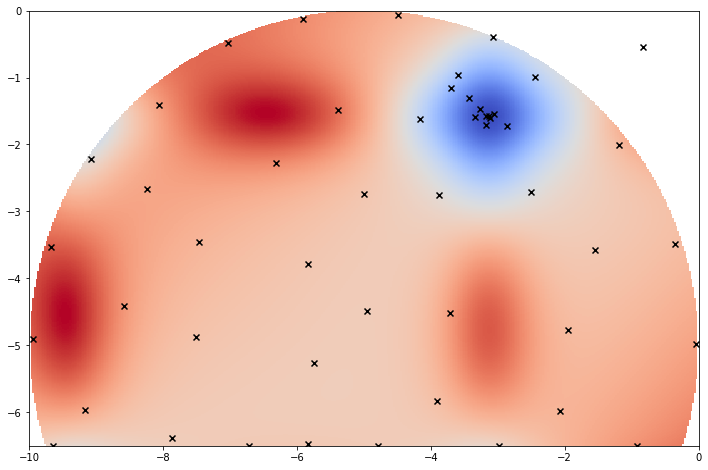

In [7]:
fig = plt.figure(figsize = (12,12))
ax.set_aspect('equal')

plt.imshow(zv.T,cmap=cm.coolwarm,extent=(-10.,0,-6.5,0),origin='bottom')
plt.scatter(X_step[:,0],X_step[:,1],marker='x',color='black')

plt.xlim(-10.,0)
plt.ylim(-6.5,0)

plt.show()

Analyzing how fast the Bayesian Optimization converge to the global minimum:

In [8]:
X_val = X_step[C_step[:,0]>=0]
Y_val = Y_step[C_step[:,0]>=0]
C_val = C_step[C_step[:,0]>=0]

A_val = np.hstack((X_val,Y_val,C_val))

T = 0
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = -10
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = -25
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = -50
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
T = -100
print(np.argwhere(A_val[:,2]<T)[0,0],X_val[np.argwhere(A_val[:,2]<T)[0,0]],Y_val[np.argwhere(A_val[:,2]<T)[0,0]])
print(np.argmin(Y_val,axis=0),X_val[np.argmin(Y_val,axis=0)],Y_val[np.argmin(Y_val,axis=0)])

2 [-4.166667 -1.625   ] [-31.746589]
2 [-4.166667 -1.625   ] [-31.746589]
2 [-4.166667 -1.625   ] [-31.746589]
5 [-3.691251 -1.157511] [-55.408939]
8 [-3.263321 -1.46496 ] [-102.474274]
[11] [[-3.130692 -1.576527]] [[-106.760172]]


In [9]:
print("Point step where minimium was found: ",np.argmin(Y_step))
print("Exact Global minima: ")
print(np.array([-3.1302468,-1.5821422,-106.7645367]))
print("Global minima found: ")
print(np.hstack((X_step[Y_step[:,0]<-106,:],Y_step[Y_step<-106][:,np.newaxis])))

Point step where minimium was found:  12
Exact Global minima: 
[  -3.130247   -1.582142 -106.764537]
Global minima found: 
[[  -3.130692   -1.576527 -106.760172]
 [  -3.109568   -1.607684 -106.615469]
 [  -3.17479    -1.571172 -106.474427]]


Creating a series of .jpg files so one can create a gif with the dynamic visualization of the Bayesian Optimization loop:

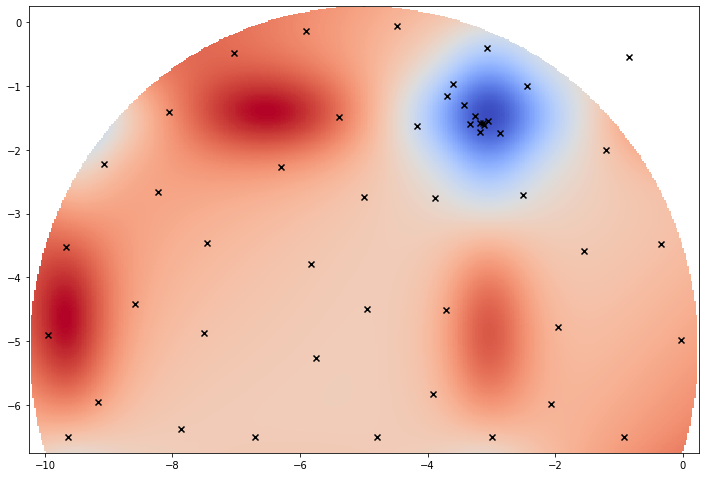

In [11]:
import os

if(not os.path.exists("gif")):
    os.mkdir("gif")

fig = plt.figure(figsize = (12,12))
plt.xlim((-1.65,1.65))
plt.ylim((-.65,2.65))
for n in range(iter_count):
    fig.clf()
    plt.xlim((-10.25,0.25))
    plt.ylim((-6.75,0.25))
    plt.imshow(zv.T,cmap=cm.coolwarm,aspect ='equal',origin='lower',extent=(-10.25,0.25,-6.75,0.25))
    plt.scatter(X_step[0:(n+num_init),0],X_step[0:(n+num_init),1],c='black',marker='x')
    plt.savefig("gif/BO_mishra_bird-MC1-"+str(n)+"-("+typ_init+","+str(num_init)+").png", bbox_inches='tight')